In [ ]:
!nvidia-smi

Tue Jul 13 15:22:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    30W /  70W |   6736MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
## NOTE: UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI
stable = False # True: latest version from github, False: stable version in pip
if stable: 
    !pip install -Uqq tsai
else:      
    !pip install -Uqq git+https://github.com/timeseriesAI/tsai.git

## NOTE: REMEMBER TO RESTART YOUR RUNTIME ONCE THE INSTALLATION IS FINISHED

In [2]:
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.19
fastai     : 2.4.1
fastcore   : 1.3.20
torch      : 1.9.0+cu102


In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


'acc_data','label','clabel','dam_name_all','dam_vals_all'

In [4]:
import pandas as pd
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt

# prepare

In [5]:

data_path = "/content/drive/MyDrive/Colab_Notebooks/ts_shm_data/frame_data_sets_3000.mat"

# data_path = "drive/MyDrive/Colab_Notebooks/ts_shm_data/d.csv"
# d = pd.read_csv(data_path, header=None, index_col=None).values

mat_data = scio.loadmat(data_path)
acc_data = mat_data.get('acc_data')
label = mat_data.get('label')
label = label[:,0:4]

In [6]:
label, acc_data.shape, label.shape

(array([[1.   , 1.   , 1.   , 1.   ],
        [0.864, 0.729, 0.987, 0.783],
        [0.94 , 0.974, 0.826, 0.742],
        ...,
        [1.   , 1.   , 0.942, 0.729],
        [0.815, 0.838, 0.772, 0.722],
        [0.859, 0.702, 0.742, 0.823]]), (3000, 4, 3001), (3000, 4))

In [7]:
data_path = "/content/drive/MyDrive/Colab_Notebooks/ts_shm_data/frame_data_sets_test.mat"

# data_path = "drive/MyDrive/Colab_Notebooks/ts_shm_data/d.csv"
# d = pd.read_csv(data_path, header=None, index_col=None).values

mat_data_test = scio.loadmat(data_path)
acc_data_test = mat_data_test.get('acc_data')
label_test = mat_data_test.get('label')
label_test = label_test[:,0:4]

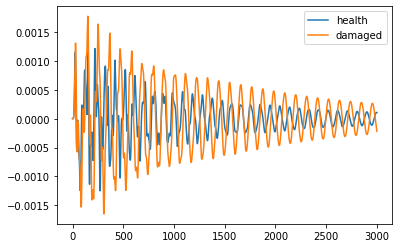

In [111]:
import sys
fig = plt.figure()
ax = fig.add_subplot(111)
h1, = ax.plot(acc_data[0,3,0:])
h2, = ax.plot(acc_data[10,3,0:])
# ax.plot(acc_data[2,3,0:])
# ax.plot(acc_data[5,3,0:])
ax.legend((h1,h2),("health","damaged"))
plt.show()

In [9]:
def convert_label(label):
  row, col = label.shape
  y = []
  for i in range(row):
    label_i = []
    for j in range(col):
      if label[i,j]==1:
        pass
      else:
        na = 'k' + str(j+1)
        label_i.append(na)
    if len(label_i)==0:
      label_i = ['nod']
    y.append(label_i)
  y = np.array(y,dtype=object)
  return y

In [10]:
y = convert_label(label)
y[0:5]

array([list(['nod']), list(['k1', 'k2', 'k3', 'k4']),
       list(['k1', 'k2', 'k3', 'k4']), list(['k1', 'k2', 'k3', 'k4']),
       list(['k2', 'k4'])], dtype=object)

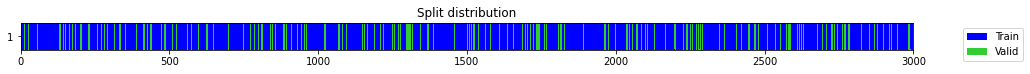

((#2400) [1575,2254,2404,1670,1999,521,2806,2392,1376,1931...],
 (#600) [2040,145,2202,1104,563,2783,2416,1111,183,2302...])

In [11]:
splits_y = get_splits(y, valid_size=.2, stratify=True, random_state=23, shuffle=True)
splits_y

# FCN

In [34]:
bs = 64

tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [TSMagAddNoise(magnitude=1)]
dsets = TSDatasets(acc_data, y, tfms=tfms, splits=splits_y)
dls_FCN = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f62e630d890>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f62e6685210>)

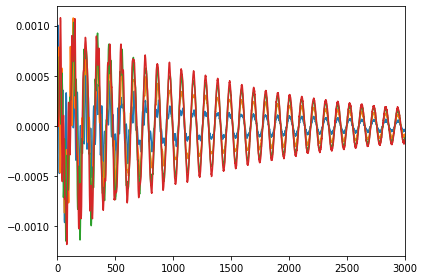

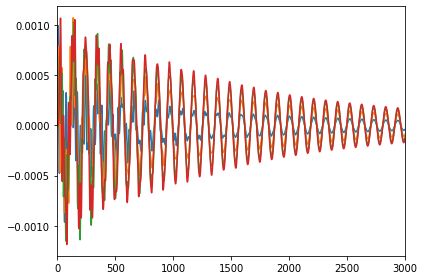

In [35]:
xb, yb = next(iter(dls_FCN.train))
xx = TSMagAddNoise(magnitude=0.5)(xb, split_idx=0)
xx.show(), xb.show()

In [52]:

model = create_model(FCN, dls=dls_FCN)
learn_FCN = Learner(dls_FCN, model, metrics=[partial(accuracy_multi, by_sample=True), partial(accuracy_multi, by_sample=False)], loss_func=BCEWithLogitsLossFlat())


SuggestedLRs(valley=0.006918309722095728)

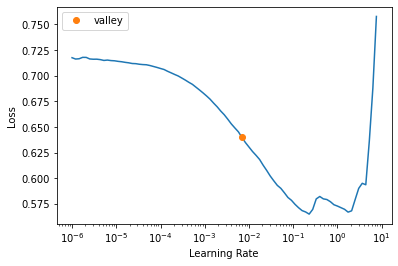

In [53]:
learn_FCN.lr_find(start_lr=1e-06, end_lr=1e2)

epoch,train_loss,valid_loss,accuracy_multi,accuracy_multi,time
0,0.675634,0.676836,0.000000,0.495333,00:04
1,0.645288,0.672128,0.000000,0.495333,00:03
2,0.618737,0.608772,0.160000,0.721667,00:04
3,0.593075,0.567366,0.300000,0.760000,00:04
4,0.568357,0.543118,0.305000,0.765000,00:04
5,0.543537,0.519276,0.301667,0.774000,00:04
6,0.517111,0.490019,0.318333,0.782000,00:04
7,0.489751,0.467763,0.325000,0.809667,00:04
8,0.461716,0.434965,0.348333,0.819667,00:04
9,0.431693,0.402236,0.363333,0.825000,00:04



training time: 00:08:29


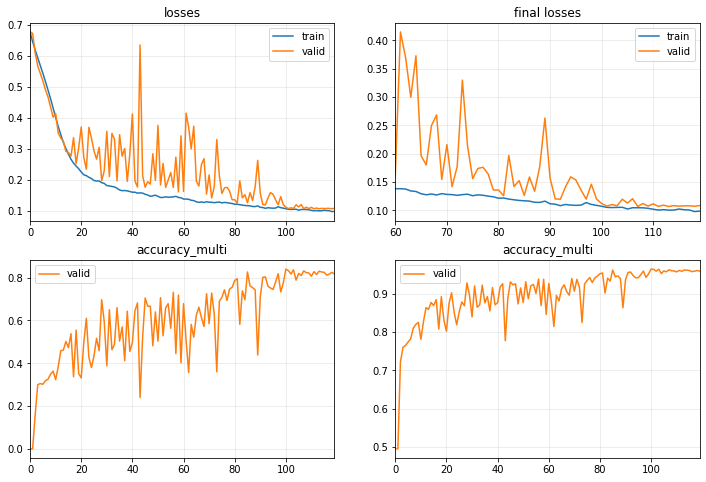

In [54]:
epochs = 120
start = time.time()
learn_FCN.fit_one_cycle(epochs, lr_max=1e-3)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")
learn_FCN.plot_metrics()

In [57]:
PATH = Path('./models/Multilabel_FCN.pkl')
PATH.parent.mkdir(parents=True, exist_ok=True)
learn_FCN.export(PATH)

## FCN Test

In [85]:
def label_to_binary(label):
  blabel = [0,0,0,0]
  for i in range(len(label)):
    if label[i]=='k1':
      blabel[0] = 1
    elif label[i]=='k2':
      blabel[1] = 1
    elif label[i]=='k3':
      blabel[2] = 1
    elif label[i]=='k4':
      blabel[3] = 1
    elif label[i]=='nod':
      blabel = [1,1,1,1]
  # if len(label)==0:
  #   blabel = [1,1,1,1]
  return blabel
      

def show_pred(y,pred,row,col,x_ticks=['k1','k2','k3','k4'],fs=(10,10)):
  N = row * col
  N = np.min([y.shape[0],N])
  index = np.arange(y.shape[0])
  np.random.shuffle(index)
  index = index[0:N].astype(np.int32)

  print(index)
  
  width = 0.3
  x = np.arange(len(x_ticks))

  fig, axes = plt.subplots(row,col,figsize=fs)
  axis = [j for i in axes for j in i]

  for i in range(N):
    y1 = y[index[i]]
    y2 = label_to_binary(pred[index[i]])
    # print(y[i])
    # print(pred[i])
    # print(y1)
    # print(y2)
    axis[i].bar(x - width/2, y1, width, label='label')
    axis[i].bar(x + width/2, y2, width, label='pred')
    axis[i].set_xticks(x)
    axis[i].set_xticklabels(x_ticks)
  plt.show()


In [86]:
label_test

array([[1.   , 1.   , 1.   , 1.   ],
       [1.   , 1.   , 0.94 , 0.746],
       [0.864, 0.709, 0.755, 0.977],
       [0.749, 0.91 , 0.769, 0.994],
       [0.734, 0.837, 1.   , 0.778],
       [1.   , 0.951, 1.   , 0.856],
       [1.   , 0.736, 0.812, 1.   ],
       [1.   , 1.   , 0.954, 0.708],
       [0.971, 0.707, 0.895, 0.991],
       [1.   , 0.849, 0.711, 0.763],
       [1.   , 0.851, 1.   , 0.892],
       [1.   , 0.92 , 0.968, 0.946],
       [1.   , 1.   , 1.   , 0.934],
       [1.   , 0.838, 0.903, 1.   ],
       [0.964, 0.851, 0.701, 0.704],
       [1.   , 1.   , 1.   , 0.703],
       [1.   , 0.813, 1.   , 1.   ],
       [0.973, 0.969, 0.795, 0.838],
       [0.817, 0.926, 1.   , 0.779],
       [1.   , 0.763, 1.   , 0.859],
       [1.   , 0.969, 0.919, 1.   ],
       [0.978, 0.836, 0.829, 0.993],
       [0.804, 0.764, 0.751, 1.   ],
       [0.725, 0.731, 0.904, 1.   ],
       [1.   , 0.755, 1.   , 1.   ],
       [1.   , 1.   , 1.   , 0.908],
       [0.935, 0.788, 0.919, 1.   ],
 

In [58]:
PATH = Path('./models/Multilabel_FCN.pkl')
learn_FCN_gpu = load_learner(PATH, cpu=False)

In [59]:
# gpu, many samples, multilabel
probas_FCN, _, preds_FCN = learn_FCN_gpu.get_X_preds(acc_data_test)

In [60]:
preds_FCN

(#50) [[],['k3', 'k4'],['k1', 'k2', 'k3', 'k4'],['k1', 'k2', 'k3'],['k1', 'k2', 'k4'],['k2', 'k4'],['k2', 'k3'],['k3', 'k4'],['k1', 'k2', 'k3'],['k2', 'k3', 'k4']...]

In [87]:
preds_FCN[-10:],label_test[-10:]

((#10) [['k1', 'k2'],['k2', 'k3'],['k2'],['k1', 'k2', 'k3', 'k4'],['k1', 'k4'],['k2', 'k4'],['k1', 'k2', 'k3', 'k4'],['k2', 'k3'],['k1', 'k2', 'k3', 'k4'],['k1', 'k2', 'k3']],
 array([[0.866, 0.927, 1.   , 1.   ],
        [1.   , 0.902, 0.801, 1.   ],
        [1.   , 0.914, 1.   , 1.   ],
        [0.923, 0.79 , 0.746, 0.784],
        [0.911, 1.   , 1.   , 0.863],
        [1.   , 0.711, 1.   , 0.88 ],
        [0.92 , 0.934, 0.937, 0.894],
        [0.975, 0.728, 0.798, 0.99 ],
        [0.758, 0.741, 0.897, 0.887],
        [0.912, 0.886, 0.828, 1.   ]]))

In [88]:
label_test.shape, len(preds_FCN)

((50, 4), 50)

[17 29  0 23 30  7 19 36  4 41 44 43 16 24 49  2 45 13 12  5 46 40 14 35
 38  8 31 11 27 10  6 32 39 25 20 15 33 42 47  9 48  3 26 28 37 22 18  1
 21]


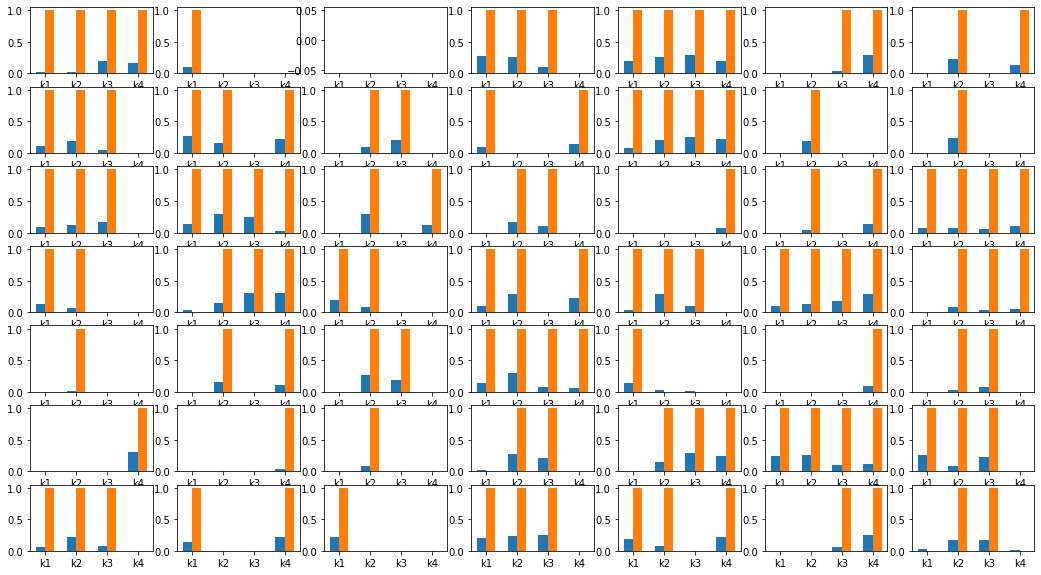

In [90]:
show_pred(1-label_test,preds_FCN,7,7,fs=(18,10))

## multilabel_confusion_matrix

In [63]:
from sklearn.metrics import multilabel_confusion_matrix


In [91]:
ym_test_ture = np.copy(label_test)
ym_test_ture[ym_test_ture==1]=0
ym_test_ture[ym_test_ture>0]=1
ym_test_ture

array([[0., 0., 0., 0.],
       [0., 0., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 0., 1.],
       [0., 1., 0., 1.],
       [0., 1., 1., 0.],
       [0., 0., 1., 1.],
       [1., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 0., 1.],
       [0., 1., 1., 1.],
       [0., 0., 0., 1.],
       [0., 1., 1., 0.],
       [1., 1., 1., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 1., 1., 1.],
       [1., 1., 0., 1.],
       [0., 1., 0., 1.],
       [0., 1., 1., 0.],
       [1., 1., 1., 1.],
       [1., 1., 1., 0.],
       [1., 1., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 1., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 1.],
       [1., 1., 0., 0.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [0., 0., 0., 1.],
       [1., 0., 1., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 0., 0., 0.],
       [1., 1., 1., 1.],
       [1., 1., 1., 0.],


In [92]:
ym_test_pred = [label_to_binary(l) for l in preds_FCN]
ym_test_pred = np.array(ym_test_pred)
ym_test_pred

array([[0, 0, 0, 0],
       [0, 0, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 0],
       [1, 1, 0, 1],
       [0, 1, 0, 1],
       [0, 1, 1, 0],
       [0, 0, 1, 1],
       [1, 1, 1, 0],
       [0, 1, 1, 1],
       [0, 1, 0, 1],
       [0, 1, 1, 1],
       [0, 0, 0, 1],
       [0, 1, 1, 0],
       [0, 1, 1, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [1, 1, 1, 1],
       [1, 1, 0, 1],
       [0, 1, 0, 1],
       [0, 1, 1, 0],
       [0, 1, 1, 0],
       [1, 1, 1, 0],
       [1, 1, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [1, 1, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [0, 0, 0, 1],
       [1, 0, 1, 0],
       [1, 1, 0, 0],
       [1, 1, 1, 0],
       [1, 0, 0, 0],
       [1, 1, 0, 1],
       [1, 0, 0, 0],
       [1, 1, 0, 0],
       [0, 1, 1, 0],
       [0, 1, 0, 0],
       [1, 1, 1, 1],
       [1, 0, 0, 1],
       [0, 1, 0, 1],
       [1, 1, 1, 1],
       [0, 1,

In [97]:
vis_arr = multilabel_confusion_matrix(ym_test_ture, ym_test_pred)
vis_arr

array([[[21,  0],
        [ 3, 26]],

       [[11,  0],
        [ 2, 37]],

       [[21,  0],
        [ 2, 27]],

       [[20,  0],
        [ 4, 26]]])

In [96]:
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
  df_cm = pd.DataFrame(
      confusion_matrix, index=class_names, columns=class_names,
  )

  try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
  except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
  axes.set_ylabel('True label')
  axes.set_xlabel('Predicted label')
  axes.set_title("Confusion Matrix for the class - " + class_label)

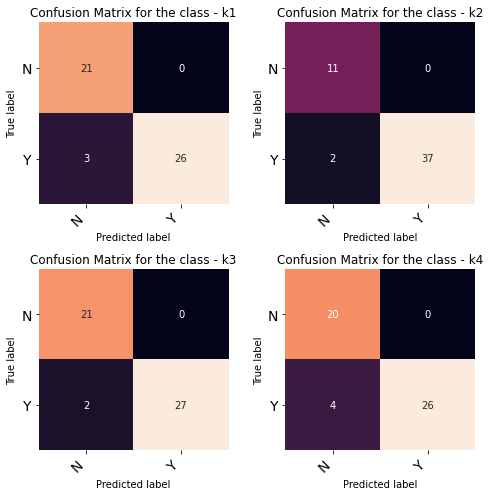

In [103]:
title_label = ["".join("k" + str(i+1)) for i in range(0, 4)]
fig, ax = plt.subplots(2, 2, figsize=(7, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, title_label):
  print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

# Inceptiontim

In [ ]:
tfms  = [None, TSMultiLabelClassification()] # TSMultiLabelClassification() == [MultiCategorize(), OneHotEncode()]
batch_tfms = [TSMagAddNoise(magnitude=1), TSStandardize()]
dls_incept = get_ts_dls(acc_data, y, splits=splits_y, tfms=tfms, batch_tfms=batch_tfms, bs=[64, 128])
dls_incept.dataset

(#800) [(TSTensor(vars:4, len:3001), TensorMultiCategory([0., 1., 0., 0., 0.])),(TSTensor(vars:4, len:3001), TensorMultiCategory([0., 1., 0., 0., 0.])),(TSTensor(vars:4, len:3001), TensorMultiCategory([1., 1., 1., 1., 0.])),(TSTensor(vars:4, len:3001), TensorMultiCategory([1., 1., 1., 1., 0.])),(TSTensor(vars:4, len:3001), TensorMultiCategory([1., 1., 1., 1., 0.])),(TSTensor(vars:4, len:3001), TensorMultiCategory([1., 1., 1., 1., 0.])),(TSTensor(vars:4, len:3001), TensorMultiCategory([1., 1., 0., 1., 0.])),(TSTensor(vars:4, len:3001), TensorMultiCategory([0., 0., 1., 1., 0.])),(TSTensor(vars:4, len:3001), TensorMultiCategory([1., 0., 0., 1., 0.])),(TSTensor(vars:4, len:3001), TensorMultiCategory([0., 0., 1., 0., 0.]))...]

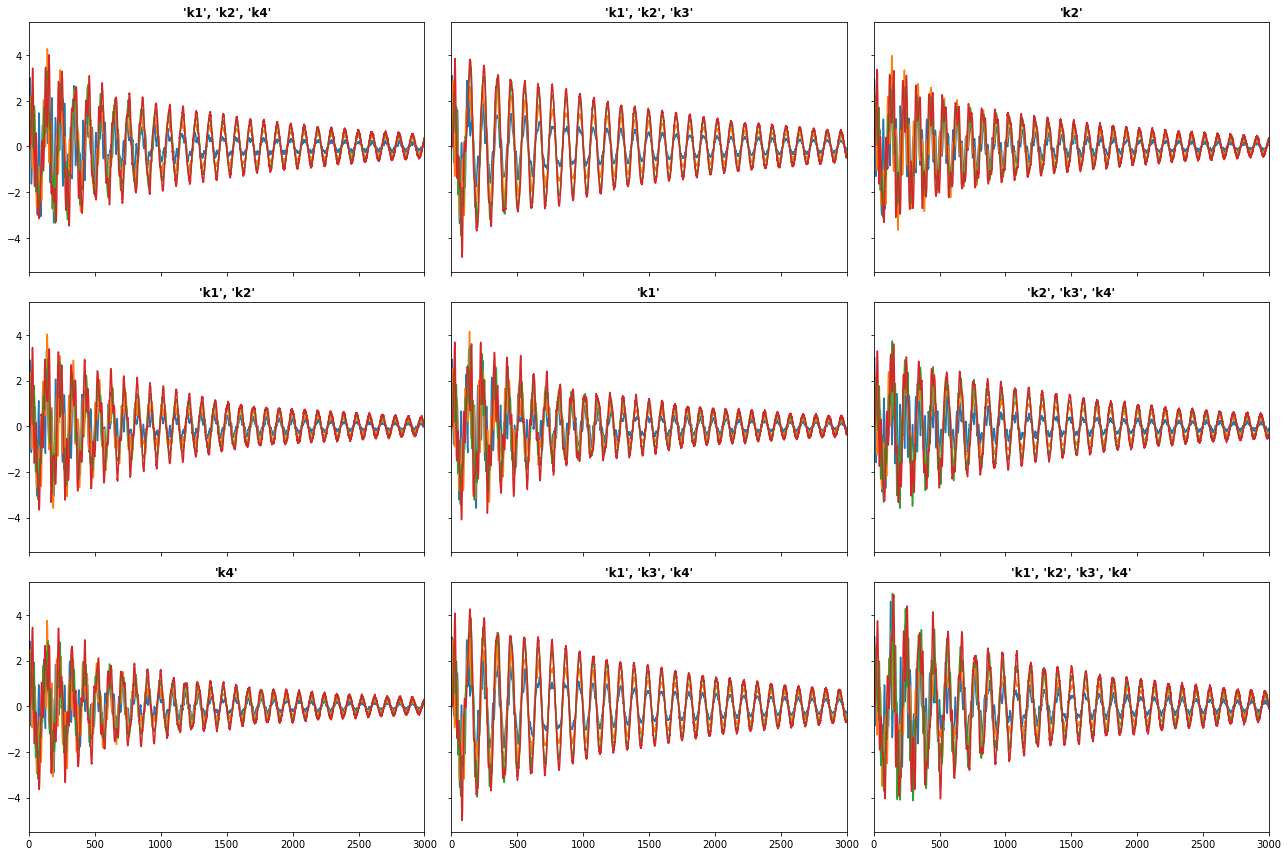

In [ ]:
dls_incept.show_batch(sharey=True)

In [ ]:
xb, yb = next(iter(dls_incept.train))

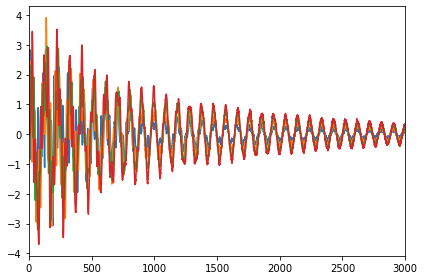

In [ ]:
xb[0].show()

In [ ]:

def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True, by_sample=False):
    "Computes accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    correct = (inp>thresh)==targ.bool()
    if by_sample:
        return (correct.float().mean(-1) == 1).float().mean()
    else:
        inp,targ = flatten_check(inp,targ)
        return correct.float().mean()

def precision_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Computes precision when `inp` and `targ` are the same size."
    
    inp,targ = flatten_check(inp,targ)
    if sigmoid: inp = inp.sigmoid()
    pred = inp>thresh
    
    correct = pred==targ.bool()
    TP = torch.logical_and(correct,  (targ==1).bool()).sum()
    FP = torch.logical_and(~correct, (targ==0).bool()).sum()

    precision = TP/(TP+FP)
    return precision

def recall_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Computes recall when `inp` and `targ` are the same size."
    
    inp,targ = flatten_check(inp,targ)
    if sigmoid: inp = inp.sigmoid()
    pred = inp>thresh
    
    correct = pred==targ.bool()
    TP = torch.logical_and(correct,  (targ==1).bool()).sum()
    FN = torch.logical_and(~correct, (targ==1).bool()).sum()

    recall = TP/(TP+FN)
    return recall

def specificity_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Computes specificity (true negative rate) when `inp` and `targ` are the same size."
    
    inp,targ = flatten_check(inp,targ)
    if sigmoid: inp = inp.sigmoid()
    pred = inp>thresh
    
    correct = pred==targ.bool()
    TN = torch.logical_and(correct,  (targ==0).bool()).sum()
    FP = torch.logical_and(~correct, (targ==0).bool()).sum()

    specificity = TN/(TN+FP)
    return specificity

def balanced_accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Computes balanced accuracy when `inp` and `targ` are the same size."
    
    inp,targ = flatten_check(inp,targ)
    if sigmoid: inp = inp.sigmoid()
    pred = inp>thresh
    
    correct = pred==targ.bool()
    TP = torch.logical_and(correct,  (targ==1).bool()).sum()
    TN = torch.logical_and(correct,  (targ==0).bool()).sum()
    FN = torch.logical_and(~correct, (targ==1).bool()).sum()
    FP = torch.logical_and(~correct, (targ==0).bool()).sum()

    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    balanced_accuracy = (TPR+TNR)/2
    return balanced_accuracy

def Fbeta_multi(inp, targ, beta=1.0, thresh=0.5, sigmoid=True):
    "Computes Fbeta when `inp` and `targ` are the same size."
    
    inp,targ = flatten_check(inp,targ)
    if sigmoid: inp = inp.sigmoid()
    pred = inp>thresh
    
    correct = pred==targ.bool()
    TP = torch.logical_and(correct,  (targ==1).bool()).sum()
    TN = torch.logical_and(correct,  (targ==0).bool()).sum()
    FN = torch.logical_and(~correct, (targ==1).bool()).sum()
    FP = torch.logical_and(~correct, (targ==0).bool()).sum()

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    beta2 = beta*beta
    
    if precision+recall > 0:
        Fbeta = (1+beta2)*precision*recall/(beta2*precision+recall)
    else:
        Fbeta = 0
    return Fbeta

def F1_multi(*args, **kwargs):
    return Fbeta_multi(*args, **kwargs)  # beta defaults to 1.0

SuggestedLRs(valley=tensor(0.0007))

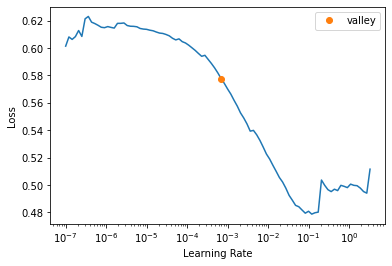

In [ ]:
metrics = [accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi,  specificity_multi, F1_multi]
learn_incept = ts_learner(dls_incept, InceptionTime, metrics=[partial(accuracy_multi, by_sample=True), partial(accuracy_multi, by_sample=False)], loss_func=BCEWithLogitsLossFlat(pos_weight=dls_incept.train.cws.sqrt()), cbs=ShowGraph())
learn_incept.lr_find()

epoch,train_loss,valid_loss,accuracy_multi,accuracy_multi,time
0,0.586259,0.605389,0.140000,0.655000,00:03
1,0.561358,0.584744,0.210000,0.702000,00:03
2,0.535630,0.524033,0.220000,0.723000,00:03
3,0.504144,0.492415,0.235000,0.757000,00:03
4,0.468981,0.382141,0.350000,0.836000,00:03
5,0.434832,0.395931,0.280000,0.787000,00:03
6,0.400559,0.349875,0.390000,0.844000,00:03
7,0.369930,0.593323,0.215000,0.729000,00:03
8,0.340836,0.450845,0.315000,0.823000,00:03
9,0.318403,0.697980,0.085000,0.642000,00:03


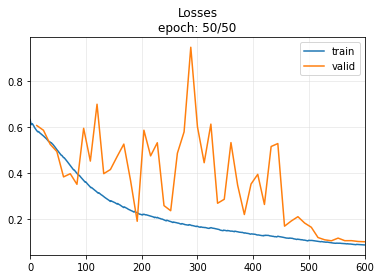

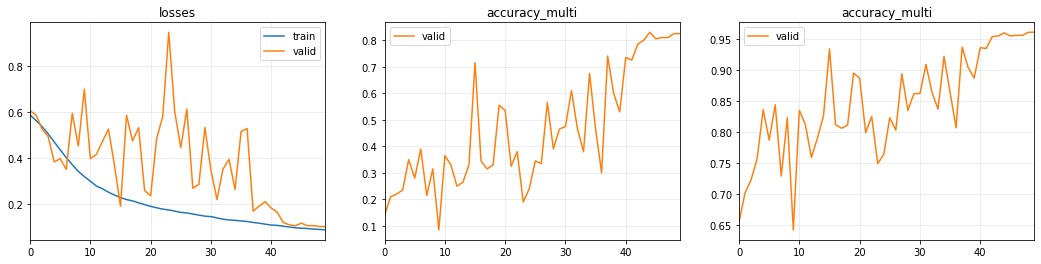

In [ ]:
epochs = 50
learn_incept.fit_one_cycle(epochs, lr_max=1e-3)

In [ ]:
PATH = Path('./models/Incept.pkl')
PATH.parent.mkdir(parents=True, exist_ok=True)
learn_incept.export(PATH)

## Inceptiontime test

In [ ]:
PATH = Path('./models/Incept.pkl')
learn_incept_gpu = load_learner(PATH, cpu=False)

In [ ]:
# gpu, many samples, multilabel
probas_incept, _, preds_incept = learn_incept_gpu.get_X_preds(acc_data_test)

[ 1 10  2 41 31  9 16  0 38 34 42 35 44 12 25 27 11  7 33 37 46 22 49 18
 13 40 26  8  4 30 43 28 32 17 47 19  5 14  3 21 24 23 45 39 15 29 36  6
 48]


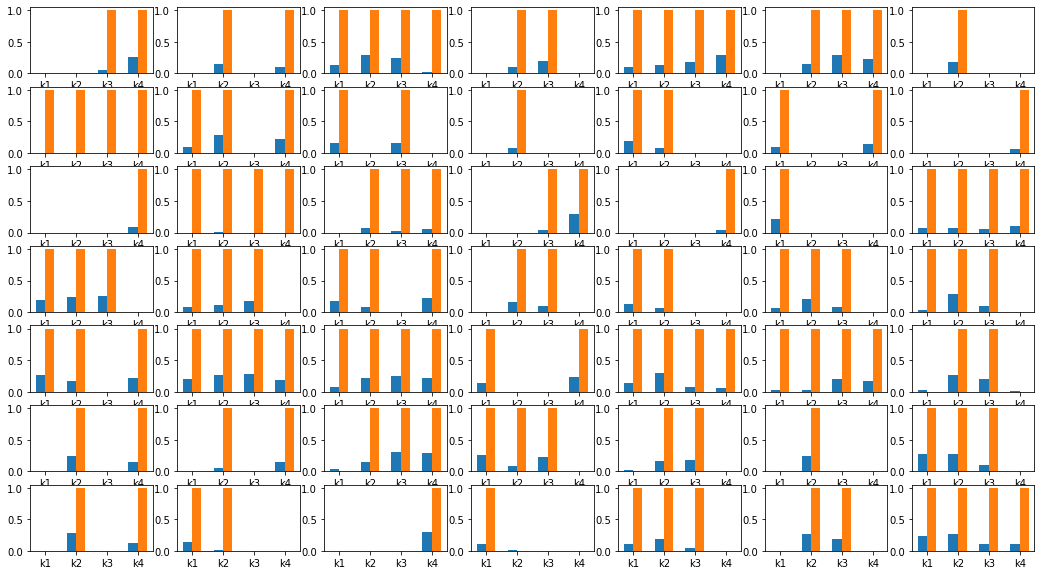

In [ ]:
show_pred(1-label_test,preds_incept,7,7,fs=(18,10))

# To Image

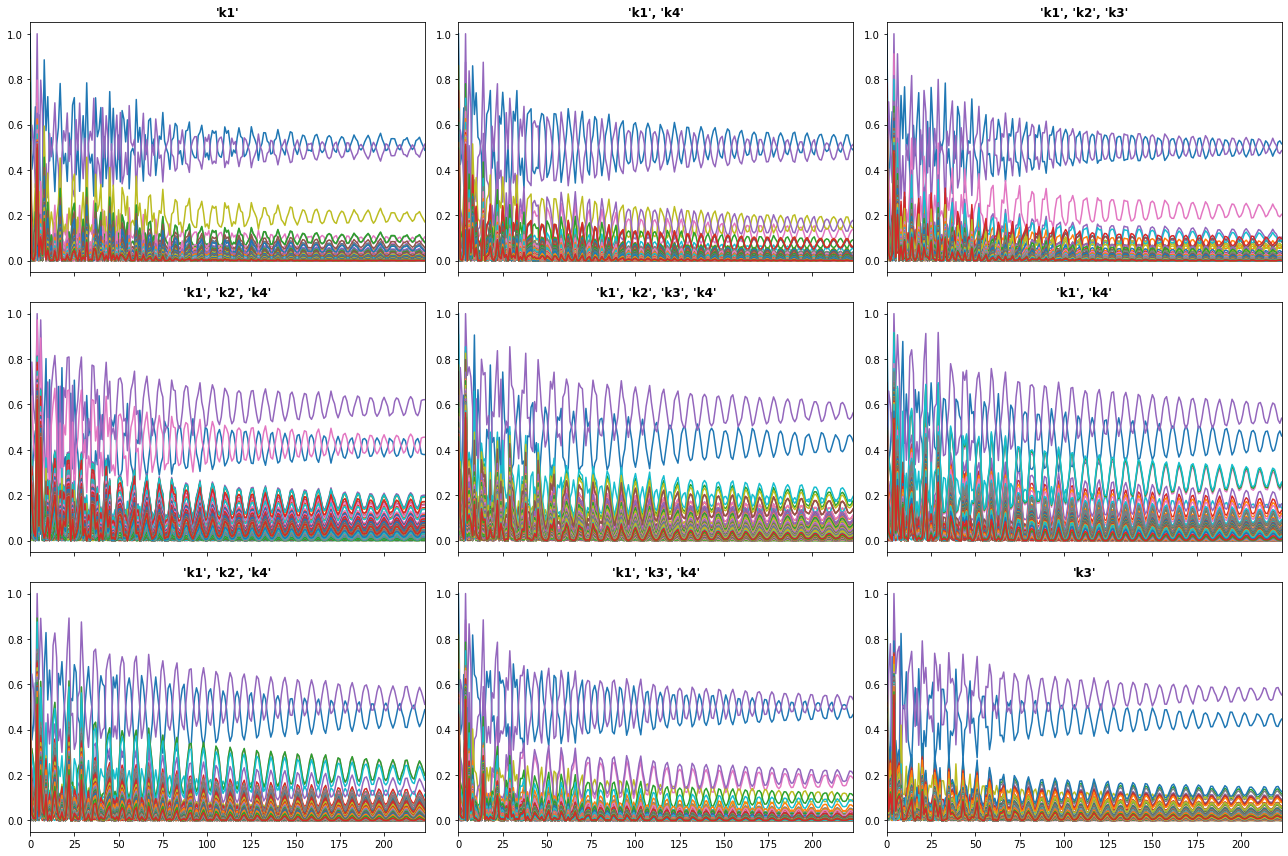

In [ ]:
tfms  = [None, [TSMultiLabelClassification()]]
batch_tfms = [TSMagAddNoise(magnitude=1), TSNormalize(), TSToGASF(range=(-1,1))]
dsets = TSDatasets(acc_data, y, tfms=tfms, splits=splits_y)
img_dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64,128], batch_tfms=batch_tfms)
img_dls.show_batch()

In [ ]:
xb, yb = next(iter(img_dls.train))

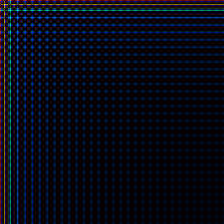

In [ ]:
xb[10].show()

In [ ]:
epochs = 40
model = create_model(xresnet18, dls=img_dls)


In [ ]:
model

XResNet(
  (0): ConvLayer(
    (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convpath): Sequential(
        (0): ConvLayer(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

epoch,train_loss,valid_loss,accuracy_multi,accuracy_multi,time
0,0.671191,0.693185,0.050000,0.567000,00:08
1,0.627895,0.643112,0.070000,0.584000,00:05
2,0.572887,0.515391,0.300000,0.782000,00:05
3,0.515927,0.403320,0.340000,0.816000,00:05
4,0.462368,0.336887,0.420000,0.854000,00:05
5,0.411183,0.289020,0.475000,0.871000,00:05
6,0.365341,0.263926,0.585000,0.898000,00:05
7,0.324221,0.274295,0.560000,0.890000,00:05
8,0.291716,0.223378,0.640000,0.908000,00:05
9,0.262358,0.256916,0.520000,0.886000,00:05



training time: 00:03:42


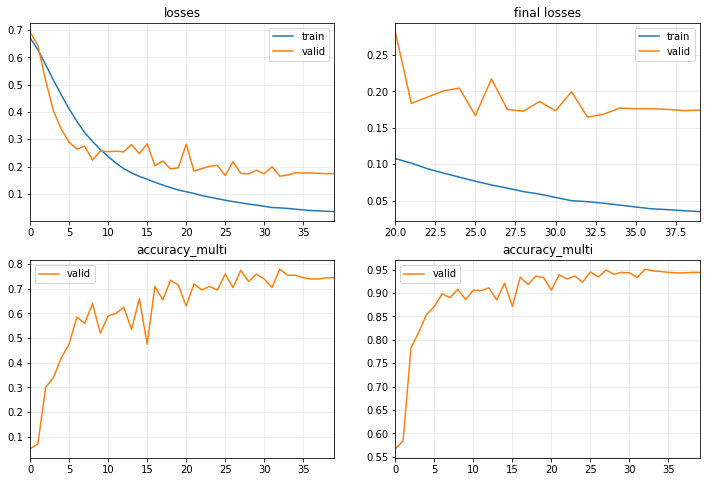

In [ ]:
learn_img = Learner(img_dls, model, metrics=[partial(accuracy_multi, by_sample=True), partial(accuracy_multi, by_sample=False)])
start = time.time()
learn_img.fit_one_cycle(epochs, lr_max=1e-3)
print(f"\ntraining time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start))}")
learn_img.plot_metrics()

In [ ]:
PATH = Path('./models/Multilabel_TSToGASF.pkl')
PATH.parent.mkdir(parents=True, exist_ok=True)
learn_img.export(PATH)

## Image-Net Test

In [ ]:
PATH = Path('./models/Multilabel_TSToGASF.pkl')
learn_img_gpu = load_learner(PATH, cpu=False)

In [ ]:
learn_img_gpu

In [ ]:
acc_data_test.shape

(50, 4, 3001)

In [ ]:
# gpu, many samples, multilabel
probas_img, _, preds_img = learn_img_gpu.get_X_preds(acc_data_test)

In [ ]:
y_test = convert_label(label_test)

[34 33 27 19  2  1 45 48 11 20 26  6 42 46 31 38  4 25  9 40 36 10 32 18
 39  3 22 17 29 43 28 37 49 23 47 12  0 41  8 24 44  5 15 16 35 14  7 13
 30]


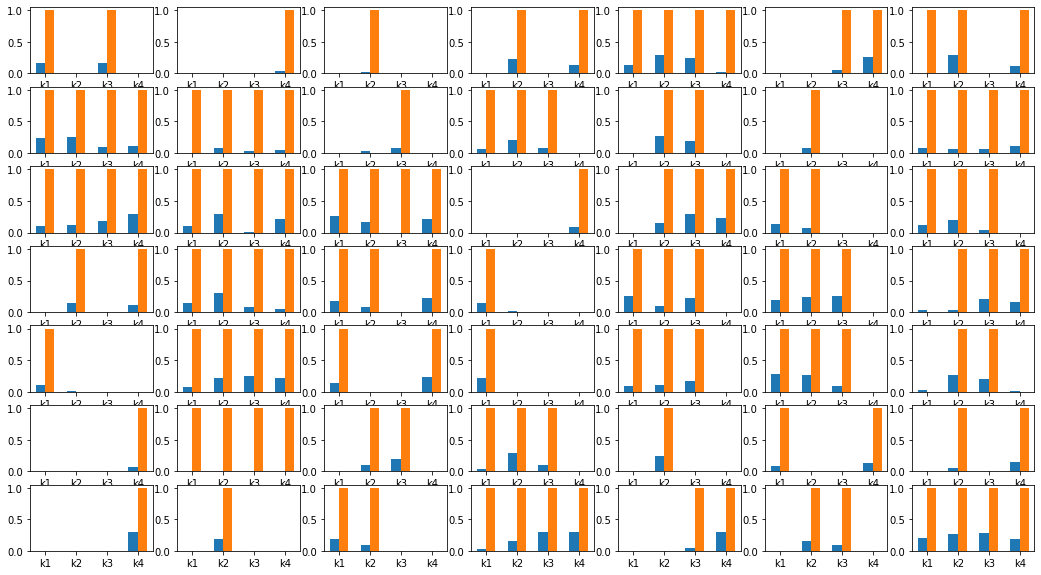

In [ ]:
show_pred(1-label_test,preds_img,7,7,fs=(18,10))

# Study And Debug

In [ ]:
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, return_split=False)
tfms = [None, Categorize()]
batch_tfms = TSStandardize()
dls = get_ts_dls(X, y, tfms=tfms, splits=splits, batch_tfms=batch_tfms, bs=128)
xb, yb = next(iter(dls.train))

In [ ]:
ss = (xb[..., 1:] - xb[..., :-1]).std(2, keepdims=True)

In [ ]:
ss.shape

torch.Size([128, 24, 1])

In [ ]:
torch.normal(0, 1/3, (2,3,4))

tensor([[[-0.0960,  0.4049, -0.4485, -0.5528],
         [ 0.2849, -0.0367,  0.2476,  0.0138],
         [-0.1823, -0.3723, -0.3860, -0.2739]],

        [[ 0.1166, -0.2804, -0.4841,  0.8517],
         [-0.6769,  0.4470,  0.2238, -0.4936],
         [-0.0816,  0.2348, -0.0560,  0.6560]]])

In [ ]:
xx = TSMagAddNoise(magnitude=0.2)(xb, split_idx=0)

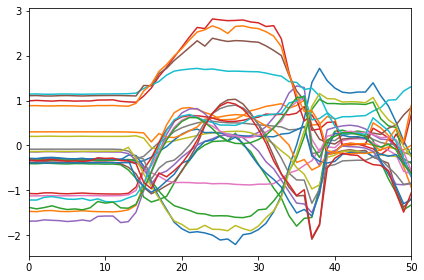

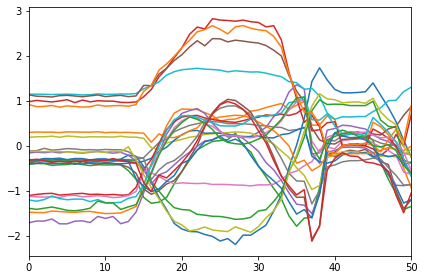

In [ ]:
xb.show()
xx.show()

In [ ]:
xb, yb = next(iter(img_dls.train))
xb[0].show();

In [ ]:
t = TSTensor(np.floor(np.random.randn(1,3,11)))
tt = TSMagAddNoise()(t, split_idx=0)

In [ ]:
t.show(), tt..show()

SyntaxError: ignored

In [ ]:
# Labeled test data
test_ds = valid_dl.dataset.add_test(X, y)# In this case I'll use X and y, but this would be your test data
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

In [ ]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds